# Exploratory Data Analysis (EDA)

In [22]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import sys
sys.path.append('../src')
from utils import load_data, load_stata_data, null_columns

In [23]:
# load the CEI dataset
data_file_path = '../data/raw/MSIA_2024_CEI_data.csv'
data = load_data(data_file_path)

### 1. Understanding the Structure


In [24]:
print("Dataset loaded successfully. Here are the first few rows:")
data.head()

Dataset loaded successfully. Here are the first few rows:


,starttime,endtime,deviceid,devicephonenum,subscriberid,simid,DATAUSE,DATE,FACTYPE,NAME_C,...,lo_hsg,lo_ckfl,lo_asst,lompiscore,mpi_poor,mpi_sevpoor,HICLIENT,CEI_type,fp_highest,pillar1
0,17-Dec-24,17-Dec-24,collect:Cd7XSswByJ0cwzOk,NaN,NaN,NaN,Yes,17-Dec-24,MSI centre,C1,...,0,0,0,16.666666,Not poor,0.0,No,Normal,IUD,0
1,17-Dec-24,17-Dec-24,collect:Cd7XSswByJ0cwzOk,NaN,NaN,NaN,Yes,17-Dec-24,MSI centre,C1,...,0,0,0,16.666666,Not poor,0.0,No,Normal,IMP,0
2,17-Dec-24,17-Dec-24,collect:Cd7XSswByJ0cwzOk,NaN,NaN,NaN,Yes,17-Dec-24,MSI centre,C1,...,0,0,0,16.666666,Not poor,0.0,No,Normal,IMP,0
3,17-Dec-24,17-Dec-24,collect:Cd7XSswByJ0cwzOk,NaN,NaN,NaN,Yes,17-Dec-24,MSI centre,C1,...,0,0,0,33.333332,Not poor,0.0,No,Normal,EC,0
4,17-Dec-24,17-Dec-24,collect:Cd7XSswByJ0cwzOk,NaN,NaN,NaN,Yes,17-Dec-24,MSI centre,C1,...,0,0,0,22.222221,Not poor,0.0,Yes,Normal,MC,0


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334 entries, 0 to 333
Columns: 380 entries, starttime to pillar1
dtypes: float64(28), int64(37), object(315)
memory usage: 991.7+ KB


In [5]:
# Read the STATA File
stata_file_path = '../data/raw/MSI_2024_CEI_Afghanistan.dta'
stata_data = load_stata_data(stata_file_path)

In [47]:
# View first five records
stata_data.head()

,starttime,endtime,deviceid,devicephonenum,subscriberid,simid,DATAUSE,DATE,FACTYPE,NAME_C,NAME_OR,NAME_SF,NAME_MSL,NAME_PSS,NAME_OTH,REGION,LOCATION,TR2DH,TR2DM,FPTYPE,FPTYPEFPMETH,FPTYPEFPREM,FPTYPEFPNO,FPTYPEFPDK,FPTYPEFPREF,FPreceived,FSTER,MSTER,IUD,IMP,INJ,OC,MC,FC,EC,OMM,REF,calculation_FP,AVAIL_FP,REMOPTS,calculation_FPREM,REMWHY,FPREMSIDE,RCYCLE,RINFECT,RMOOD,RHLTH,RWEIGHT,RSIDEOTH,RSIDEREF,REMWHERE,PAIN_REM,PAINMAN_REM,PAINOP_IMPREM,PAINOP_IMPREM1,PAINOP_IMPREM2,PAINOP_IMPREM3,PAINOP_IMPREM666,PAINOP_IMPREM999,PAINOP_IMPREM888,PAINOP_IUDREM,PAINOP_IUDREM1,PAINOP_IUDREM2,PAINOP_IUDREM3,PAINOP_IUDREM4,PAINOP_IUDREM666,PAINOP_IUDREM999,PAINOP_IUDREM888,MEDBEF_REM,PAINSCALE_DREM,PAINDUR_REM,MEDDUR_REM,PAINSCALE_AREM,PAINAFT_REM,MEDAFT_REM,PAINRES_REM,servicereceived,SAC,FPCounsel,PTEST,HIV,STI,CCS,MCH,GEN,OTHSRH,OTHGEN,ADDNONE,ADDREF,ANC_C,DELC_C,PNC_C,SACTYPE,calculation_SAC,Service_Received,FPEVER,FPWANT,FPCURR,CMETH,Prev_FPmethod,FPWHERE,CMADD,CMADDMTH,CMADDMTH1,CMADDMTH2,CMADDMTH3,CMADDMTH4,CMADDMTH5,CMADDMTH6,CMADDMTH7,CMADDMTH8,CMADDMTH9,CMADDMTH10,CMADDMTH11,CMADDMTH12,CMADDMTH888,CMCURWNT,CMACCESS,COUNSEL_PAFP,WNTMETH,SPCMTH,WAMETH,RECMETH,CHMETH,METHNO,METHDIFF,CMREASON,RECCOUN,FOLLUP,CONTUSE,OTHERMETH,TOLDABOUT,CHFSTER,CHMSTER,CHIUD,CHIMP,CHINJ,CHOCP,CHMC,CHFC,CHEC,CHLAM,CHOMM,CHTRAD,CHDK,CMAUTO,IMPACT,IMPEDU,IMPWRK,IMPFAM,IMPHLTH,IMPOTH,IMPNONE,IMPDK,IMPREF,REC,RET,PRIV,REST,WAIT,CARE,ENOUGH,SERIOUS,RPRT,COMFORT,GEN_SAT,HOURS,FEED,PRIVINFO,PAIN_CM,PAINMAN_CM,PAINOP_IMP,PAINOP_IMP1,PAINOP_IMP2,PAINOP_IMP3,PAINOP_IMP666,PAINOP_IMP999,PAINOP_IMP888,PAINOP_IUD,PAINOP_IUD1,PAINOP_IUD2,PAINOP_IUD3,PAINOP_IUD4,PAINOP_IUD666,PAINOP_IUD999,PAINOP_IUD888,MEDBEF_CM,PAINSCALE_DCM,PAINDUR_CM,MEDDUR_CM,PAINSCALE_ACM,PAINAFT_CM,MEDAFT_CM,PAINRES_CM,INFO,IADVERT,IRADIO,INEWS,IMEET,INET,ISOCMED,ISIGN,ISPKR,IPRMAT,MSAFG_IRELG,INFOOTH,INFONO,AWRTIME,REFER,RCBM,RPUBPROV,RPRIVPROV,RREFU,RREFNU,REFNONE,CCUSE_BEF,CELLOWN,POSIPC,KSANCTION,KMENSUPP,KCOMSUPP,KLEADSUP,FPDECMAK,GENDER,AGE,EDU,MAR,CHILD,PPART,IDEALFS,JOB,DISPLACED,WHERE_DISP,WHY_DISPA,WHY_DISPB,DIS1,DIS2,DIS3,DIS4,DIS5,DIS6,MPI_YS,MPI_SCA,MPI_CM,MPI_FLR,MPI_WALL,MPI_ROOF,MPI_TOSHR,MPI_TO,MPI_CF,MPI_WATDIS,MPI_WAT,MPI_ELEC,MPI_TRUCK,MPI_ASSETS,unique_id1,unique_id2,unique_id3,unique_id4,unique_id5,NUMBERQ,_id,_uuid,_submission_time,_validation_status,_notes,_status,_submitted_by,__version__,_tags,_index,FPREMTYPE,CCREAS_BEF,id,FPREM,FP,FPMETHUNK,MSP,MSMP,CHOICEtot,CHOICEtotAllMethods,othermeth_calc,filterPAIN,filterPAIN_FPMSP,filterPAINFP,NINFO,ENUMID,FPREC,REMCLIENTONLY,SACLIENT,COREMSI,FPCLIENTONLY,NMETH,countSRH,FPCLIENT,ADOPTER,SWITCH,FPNEVER,FP2020,FP2020C,FP2030,PCCC,RECCAT,RETCAT,SAT_PRIV,SAT_REST,SAT_WAIT,SAT_CARE,SAT_ENOUGH,SAT_SERIOUS,SAT_RPRT,SAT_COMFORT,SAT_PRIV_R,SAT_REST_R,SAT_WAIT_R,SAT_CARE_R,SAT_ENOUGH_R,SAT_SERIOUS_R,SAT_RPRT_R,SAT_COMFORT_R,TR2D,TR2DH2,POSIPC_A,KSANCTION_A,KMENSUPP_A,KCOMSUPP_A,KLEADSUP_A,age3grp_a,age4grp,age3grp_b,YOUTH,ADOLESCENT,MAR_BINARY,CHILD_GRP,MARPAR_GRP,NOEDUC,EDUC,DISABILITY1,DISABILITY3,DISABILITY4,filterSRH,m_educ,m_satt,m_cm,m_elct,m_wtr,m_sani,m_floor,m_roof,m_wall,m_hsg,m_ckfl,m_asst,mpiscore,hi_cm,hi_satt,hi_educ,hi_elct,hi_wtr,hi_sani,hi_hsg,hi_ckfl,hi_asst,himpiscore,lo_cm,lo_satt,lo_educ,lo_elct,lo_wtr,lo_sani,lo_hsg,lo_ckfl,lo_asst,lompiscore,mpi_poor,mpi_sevpoor,HICLIENT,CEI_type,fp_highest,pillar1
0,2024-12-17,2024-12-17,collect:Cd7XSswByJ0cwzOk,,,,1,2024-12-17,1,1.0,NaN,NaN,NaN,NaN,,666,1,0,20,FPMETH,1,0,0,0,0,IUD,0,0,1,0,0,0,0,0,0,0,0.0,IUD/IUS,1.0,1.0,,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FPCounsel,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,NaN,,IUD/IUS,1,1,1.0,7.0,Male Condoms,1.0,1.0,7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1,1.0,3.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,CHIUD,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,IMPEDU,1,0,0,0,0,0,0,0,9.0,10.0,5,5,5,5,5,5,5,5,5,1,1,1,1.0,1.0,,Na

### 2. Summary Statistics

In [6]:
# distribution of numerical columns
display()
pd.DataFrame(data.describe()).T

,count,mean,std,min,25%,50%,75%,max
NAME_SF,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NAME_PSS,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TR2DH,334.0,0.317365,0.727741,0.0,0.000000,0.000000,0.000000,6.000000
TR2DM,334.0,20.344311,15.913939,0.0,10.000000,15.000000,30.000000,60.000000
PAINOP_IMPREM,9.0,222.666667,332.500000,1.0,1.000000,1.000000,666.000000,666.000000
...,...,...,...,...,...,...,...,...
lo_ckfl,334.0,0.299401,0.458683,0.0,0.000000,0.000000,1.000000,1.000000
lo_asst,334.0,0.284431,0.451820,0.0,0.000000,0.000000,1.000000,1.000000
lompiscore,334.0,32.235529,20.201223,0.0,16.666666,33.333332,44.444443,88.888885
mpi_sevpoor,333.0,0.225225,0.418359,0.0,0.000000,0.000000,0.000000,1.000000


### 3. Data Cleaning
- Handling missing values, invalid data, etc.

In [26]:
# check columns with numm values
null_cols = null_columns(data)

list(null_cols)

['NAME_SF',
 'NAME_PSS',
 'METHDIFF',
 'unique_id3',
 'unique_id5',
 '_validation_status',
 '_notes',
 '_tags']

In [27]:
# Remove the columns with no values
data = data.drop(columns=null_cols)

In [28]:
# Replace Region => other to Central in the dataset
data['REGION'] = data['REGION'].replace('Other', 'Central')
data['REGION'].unique()

array(['Central', 'North', 'West', 'South', 'East'], dtype=object)

In [29]:
# Remove the record with maritual status as divorced/widowed/seperated

# group by marital_status
print(data.groupby('MAR').size())
print("====\n")
data = data[data['MAR'] != 'Widowed / Divorced / Separated']
print(data['MAR'].value_counts())

MAR
Married                           333
Widowed / Divorced / Separated      1
dtype: int64
====

MAR
Married    333
Name: count, dtype: int64


In [30]:
# Remove the record with displaced asnwered as 'refused'

# group by marital_status
print(data.groupby('DISPLACED').size())
print("====\n")
data = data[data['DISPLACED'] != 'Refused']
print(data['DISPLACED'].value_counts())

DISPLACED
No         290
Refused      1
Yes         42
dtype: int64
====

DISPLACED
No     290
Yes     42
Name: count, dtype: int64


### 4. Data Distribution

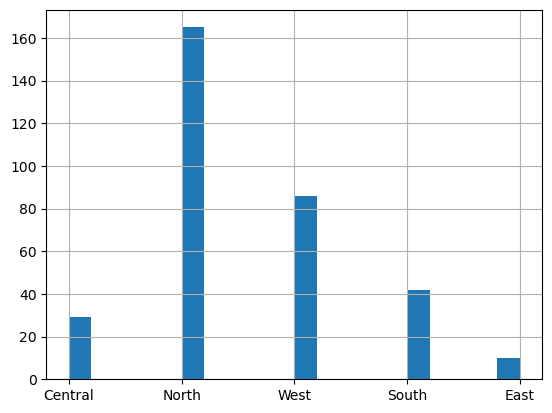

In [31]:
# Histogram: Data distribution across regions
data['REGION'].hist(bins=20)
plt.show()


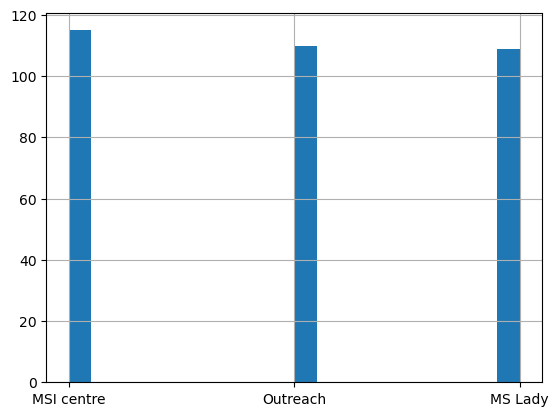

In [7]:
# Data distribution across channels
data['FACTYPE'].hist(bins=20)
plt.show()

### 5. Correlation Analysis
- Correlation matrix: To identify correlations between numerical variables

In [32]:
numerical_cols = data.select_dtypes(include=['number']).columns.drop(['_id', '_index','id'])

correlation_matrix = data[numerical_cols].corr()
correlation_matrix

,TR2DH,TR2DM,PAINOP_IMPREM,PAINSCALE_DREM,PAINSCALE_AREM,CMAUTO,PAINSCALE_DCM,PAINSCALE_ACM,AGE,CHILD,...,lo_educ,lo_elct,lo_wtr,lo_sani,lo_hsg,lo_ckfl,lo_asst,lompiscore,mpi_sevpoor,pillar1
TR2DH,1.000000,0.265805,-0.250000,0.007459,0.127046,0.138172,-0.036633,-0.053733,-0.050062,-0.039636,...,0.022185,0.054582,0.145154,-0.083482,0.077769,0.117822,0.076495,0.011440,0.030201,0.260538
TR2DM,0.265805,1.000000,0.750000,0.273928,0.415064,-0.047749,0.202383,0.343889,0.049628,0.063720,...,-0.018137,0.094527,-0.086813,-0.293280,-0.168897,0.012934,-0.048124,-0.147028,-0.099986,0.234891
PAINOP_IMPREM,-0.250000,0.750000,1.000000,0.490290,0.731272,0.391630,NaN,NaN,-0.425017,-0.304997,...,0.188982,0.188982,NaN,-0.632456,-0.377964,-0.250000,-0.250000,0.178571,NaN,-0.250000
PAINSCALE_DREM,0.007459,0.273928,0.490290,1.000000,0.886619,0.226555,NaN,NaN,0.216701,0.426944,...,-0.149516,0.213720,-0.092265,-0.293267,-0.385806,-0.285885,0.011961,-0.287559,-0.189957,-0.350263
PAINSCALE_AREM,0.127046,0.415064,0.731272,0.886619,1.000000,0.329358,NaN,NaN,0.184229,0.364070,...,0.030718,0.351745,-0.221512,-0.411721,-0.280252,-0.085791,0.054688,-0.085126,-0.221512,-0.235843
CMAUTO,0.138172,-0.047749,0.391630,0.226555,0.329358,1.000000,-0.015110,-0.029976,0.025988,-0.063475,...,-0.113591,0.028528,0.124842,-0.121111,0.067663,0.020031,0.072372,0.018157,0.000999,0.155963
PAINSCALE_DCM,-0.036633,0.202383,NaN,NaN,NaN,-0.015110,1.000000,0.697271,0.079196,0.147840,...,-0.182798,0.170717,-0.076342,-0.206253,0.202145,0.004229,0.049557,-0.202951,-0.072747,-0.039183
PAINSCALE_ACM,-0.053733,0.343889,NaN,NaN,NaN,-0.029976,0.697271,1.000000,0.094373,0.134087,...,-0.181314,0.225128,-0.169326,-0.294924,0.132602,-0.018264,0.111070,-0.174287,-0.038910,-0.045979
AGE,-0.050062,0.049628,-0.425017,0.216701,0.184229,0.025988,0.079196,0.094373,1.000000,0.735082,...,-0.124986,-0.060712,0.060149,-0.052677,0.132235,0.002937,0.004764,-0.110027,-0.062671,0.040576
CHILD,-0.039636,0.063720,-0.304997,0.426944,0.364070,-0.063475,0.147840,0.134087,0.735082,1.000000,...,-0.152900,0.138493,0.100677,-0.036311,0.194998,0.091450,0.095811,-0.088693,-0.022765,0.017784


### 6. Save the Processed Data

In [33]:
data.to_csv('../data/processed/MSIA_2024_CEI_Afghanistan_data_cleaned.csv', index=False)